# Naive representation

*First pipeline:*
* **1. Data preparation (correlation step):**
    * 1.1 image initialization (spatial domain)
    * 1.2 Fourier transform (frequency domain)
    
    &rarr; simulates radio visibility data
* **2. Data embedding (calibration step):**
    * 2.1 data pre-processing
    * 2.2 data encoding
    
    &rarr; embeds visibilities into qubits
* **3. Data reading (imaging step):**
    * 3.1 readout
    * 3.2 inverse Fourier transform (spatial domain) - IFT
    
    &rarr; approximates science-ready intermediate product  

*Second pipeline:*
* **1. Data preparation (correlation step):**
     * 1.1 image initialization (spatial domain)
     * 1.2 Fourier transform (frequency domain)
     
     &rarr; simulates radio visibility data
* **2. Data embedding (calibration step):**
    * 2.1 data pre-processing
    * 2.2 data encoding
    * 2.3 quantum inverse Fourier transform - QFT
    
    &rarr; embeds visibilities into qubits and applies QFT on qubits
* **3. Data reading (imaging step):**
    * 3.1 readout
    
    &rarr; approximates science-ready intermediate product  

*Digital encoding (binary):*

* circuit family #1 from [Cortese 2018](https://arxiv.org/abs/1803.01958)
* to many features to simulate for PennyLane's implementation - Basis embedding ([Teamplates](https://docs.pennylane.ai/en/stable/introduction/templates.html))

#### Prerequisites

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

# reverse a string (for the measurement step readout)
def reverse(string):
    string = string[::-1]
    return string

## 1. Data preparation (correlation step)

### 1.1 image initialization (spatial domain)

In [3]:
# image of the sky filled with double precision complex floats (single precision for reals/imaginaries)
# few pixels are set to relatively large complex random values in random spots (image sources)
# relatively small complex values are added (white noise from background radiations) 

n = 2 #number of antennas

sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
stars = np.random.randint(1, 11) #random number of sources
radius = 1 #np.random.randint(1, 3) #with random radius

for i in range(0, stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 8.95626984e+01+8.6716585e+00j  1.09191295e-02-1.5748914e-02j]
 [-7.43706187e-04+3.4845502e-03j -1.17713399e-02+1.0831828e-03j]]


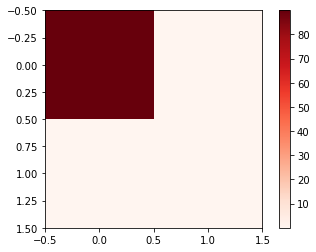

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Reds') 
cbar = plt.colorbar()

### 1.2 Fourier transform (frequency domain)

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[89.561104+8.660478j 89.562805+8.689809j]
 [89.586136+8.651341j 89.54075 +8.685006j]]


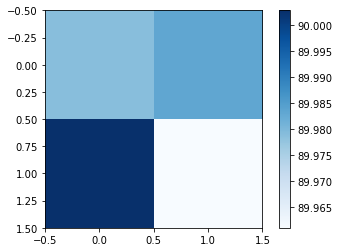

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

#### * Sanity check

In [7]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()
 
print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 1.5519906e-12
Imaginaries MSE: 1.7874038e-14


## 2. Data embedding (calibration step)

### 2.1 data pre-processing
### 2.2 data encoding

In [8]:
import qiskit
from qiskit import *
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

In [9]:
def apply_iqft(given_circuit, measurement_qubits, n):

    given_circuit.append(QFT(n).inverse(), measurement_qubits)
    

In [10]:
# encoding binary data onto qubits
def binary_encode(qc, binary, off_set):
    
    for i in range(0, len(binary)):
        qc.reset(off_set+i) # set quantum state |0> by default for all qubits

        if binary[i]=='1':
            qc.x(off_set+i) # act as a CX (controlled X gate)
    
    off_set += len(binary)

    return off_set

In [11]:
number_of_entries = visibilities.shape[0] * visibilities.shape[1]
number_of_bits_real = 32
number_of_bits_imag = 32
number_of_bits = number_of_bits_real + number_of_bits_imag
off_set = 0

# encoding (n bits encoded onto n qubits)
qc = QuantumCircuit(number_of_entries*number_of_bits)
for i in range(0, visibilities.shape[0]):
    for j in range(0, visibilities.shape[1]):
            binary_real = float_to_bin_real(visibilities[i, j].real)
            binary_imag = float_to_bin_imag(visibilities[i, j].imag)
            binary = binary_real+binary_imag
            off_set = binary_encode(qc, binary, off_set)
#qc.draw(output='text')
apply_iqft(qc, range(number_of_entries*number_of_bits), number_of_entries*number_of_bits)
#qc.draw(output='text')

## 3. Data reading

### 3.1 readout

In [12]:
# measurement
qc.measure_all()
backend = Aer.get_backend('aer_simulator') # Qiskit's staple simulator (CHOICE MOTIVATION?)
job = backend.run(qc, shots=1, memory=True) 
output = job.result().get_memory()[0]
out = reverse(output)
#print(out)

# readout
chunks_real = []
chunks_imag = []
for i in range(0, number_of_entries):
    chunks_real.append(out[number_of_bits*i:(number_of_bits*i)+number_of_bits_real]) # real parts represented every 64 bits starting from the first one
    chunks_imag.append(out[(number_of_bits*i)+number_of_bits_imag:(number_of_bits*i)+number_of_bits_imag+number_of_bits_imag]) # imaginary parts represented every 64 bits starting after the first occurence of a real part 

readout = []
for i in range(0, len(chunks_real)):
    readout.append(complex(bin_to_float_real(chunks_real[i]), bin_to_float_imag(chunks_imag[i]))) 

readout = np.array(readout).reshape(n , n).astype('complex64')
print(readout)

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Circuit circuit-89 contains invalid instructions {"gates": {IQFT}} for "statevector" method.Insufficient memory to run circuit circuit-89 using the statevector simulator. Required memory: 281474976710656M, max memory: 8112M


QiskitError: 'ERROR:  [Experiment 0] Circuit circuit-89 contains invalid instructions {"gates": {IQFT}} for "statevector" method.Insufficient memory to run circuit circuit-89 using the statevector simulator. Required memory: 281474976710656M, max memory: 8112M ,  ERROR: Circuit circuit-89 contains invalid instructions {"gates": {IQFT}} for "statevector" method.Insufficient memory to run circuit circuit-89 using the statevector simulator. Required memory: 281474976710656M, max memory: 8112M'

### 3.2 inverse Fourier transform (spatial domain)

In [ ]:
img = np.fft.ifft2(readout).astype('complex64')

#### fidelity test

In [ ]:
test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(sky_image)
modulus2 = np.absolute(img)

axs[0].imshow(modulus1, cmap='Reds')
axs[1].imshow(modulus2, cmap='Reds')

axs[0].set_title("Original image")
axs[1].set_title("Reconstructed image")

for ax in axs.flat:
    ax.set(xlabel=n, ylabel=n)

In [ ]:
pi = np.pi
n = 4

def myQFT(n):
    myQFT = QuantumCircuit(n)
    for qbit in range(n):
        myQFT.h(qbit)
        for other_qbit in range(qbit+1, n):
            myQFT.cp( pi/(2**(other_qbit-qbit)), other_qbit, qbit)
    return myQFT
myQFT = myQFT(n)
display(myQFT.draw(output='latex'))
display(QFT(n).draw(output='mpl'))